In [1]:
!pip install tensorflow==2.11.0

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
import torch
from transformers import RobertaTokenizer, TFRobertaModel
from torch.utils.data import DataLoader, TensorDataset

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

GPU is NOT available


In [5]:
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # GPU detection
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Running on multiple GPUs')
    else:
        # Default distribution strategy in TensorFlow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
        print('Running on CPU or single GPU')

print('Number of replicas:', strategy.num_replicas_in_sync)


Running on CPU or single GPU
Number of replicas: 1


In [6]:
MODEL_NAME = 'roberta_base'
MAX_LEN = 128
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 264
EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("labeled_data.csv")

In [8]:
df1=df[df['class']==0]
df2=df[df['class']==1]
df3=df[df['class']==2]

In [9]:
df4=df2.sample(df1.shape[0])
df4.shape

(1430, 7)

In [10]:
df5=df3.sample(df1.shape[0])
df5.shape

(1430, 7)

In [11]:
train_df=pd.concat([df1,df4,df5])
train_df.shape

(4290, 7)

In [12]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [13]:
train_df['tweet'].value_counts()

tweet
RT @dontesydnor: when kanye said "mayonnaise colored benz, i push miracle whips" http://t.co/iizYdfbZCg                                         1
"@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer" gaywad                                                                                   1
Can't tell if Mexico has been impressive or if Brazil has just been trash today                                                                 1
anybody want to take me to pollo?                                                                                                               1
@ChaldeanCutie really? @RileyAintShit @KILLSheredon @CHILDISHCUDl are my nudes trash?                                                           1
                                                                                                                                               ..
"@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward" but at least he isn't a cripple like your hero Roach lm

In [14]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [15]:
# text processing function

import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line
    text = re.sub(r'[^ \w\.]', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    return text
# Create a new column called "Text" for collecting clean text
train_df['Text'] = train_df.tweet.apply(lambda x: clean_text(x))

In [16]:
X_data = train_df[['Text']].to_numpy().reshape(-1)
y_data = train_df[['class']].to_numpy().reshape(-1)

In [17]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,Text
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",queer gaywad
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...",alsarabsss hes a beaner smh you can tell hes...
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",youre fucking gay blacklisted hoe holding ou...
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...",lmfaoooo i hate black people this is why the...
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...",at least im not a nigger


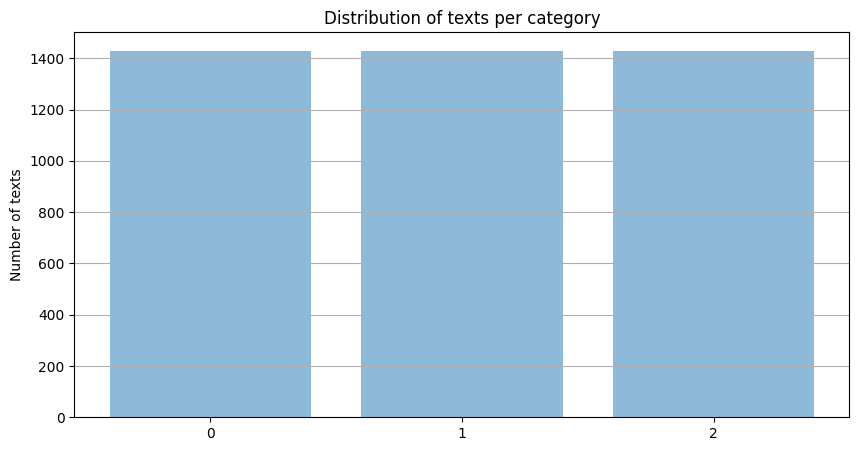

Counter({0: 1430, 1: 1430, 2: 1430})


In [18]:
categories = train_df[['class']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [19]:
def calculate_stats(train_df, split_char=' '):
    categories = train_df['class'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in train_df.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['class']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = train_df['class'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [20]:
df_stats = calculate_stats(train_df)
df_stats['per_category']

,lengths,mean,stdev
0,"[3, 12, 11, 14, 8, 20, 20, 6, 10, 17, 12, 7, 2...",13.106294,6.824494
1,"[27, 4, 8, 16, 28, 10, 24, 10, 15, 20, 11, 8, ...",13.028671,6.448473
2,"[7, 22, 8, 17, 16, 24, 16, 13, 20, 13, 25, 3, ...",13.646154,6.523734


In [21]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_df['class'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 4290
Number of categories: 3
Done!


In [22]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [24]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [25]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [26]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import albert model from HuggingFace
        model = TFRobertaModel.from_pretrained('roberta-base')
        x = model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [27]:
strategy = tf.distribute.get_strategy()

In [28]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [29]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/5


12/12 [==============================] - 484s 38s/step - loss: 1.0432 - accuracy: 0.4525 - val_loss: 0.7765 - val_accuracy: 0.6488
Epoch 2/5
12/12 [==============================] - 455s 38s/step - loss: 0.7296 - accuracy: 0.6690 - val_loss: 0.5909 - val_accuracy: 0.7607
Epoch 3/5
12/12 [==============================] - 456s 38s/step - loss: 0.5531 - accuracy: 0.7679 - val_loss: 0.5605 - val_accuracy: 0.7762
Epoch 4/5
12/12 [==============================] - 458s 39s/step - loss: 0.4776 - accuracy: 0.8075 - val_loss: 0.5438 - val_accuracy: 0.7809
Epoch 5/5
12/12 [==============================] - 458s 38s/step - loss: 0.4202 - accuracy: 0.8242 - val_loss: 0.5439 - val_accuracy: 0.7933


In [30]:
model_filename = 'Roberta_base_davidson.pkl'
joblib.dump(model, model_filename)
print("Model saved as:", model_filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......tf_roberta_model
.........layers
............tf_roberta_main_layer
...............embeddings
..................LayerNorm
.....................vars
........................0
........................1
..................dropout
.....................vars
..................vars
.....................0
.....................1
.....................2
...............encoder
..................layer
.....................tf_roberta_layer
........................attention
...........................dense_output
..............................LayerNorm
.................................vars
....................................0
..................................

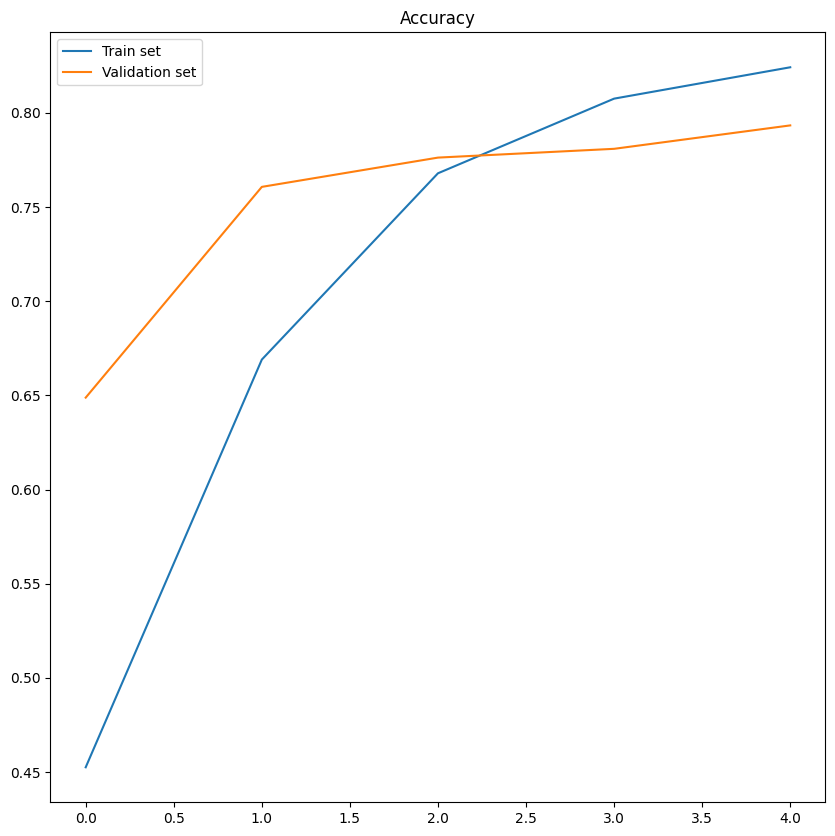

In [31]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [32]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 79.33%


41/41 [==============================] - 46s 1s/step


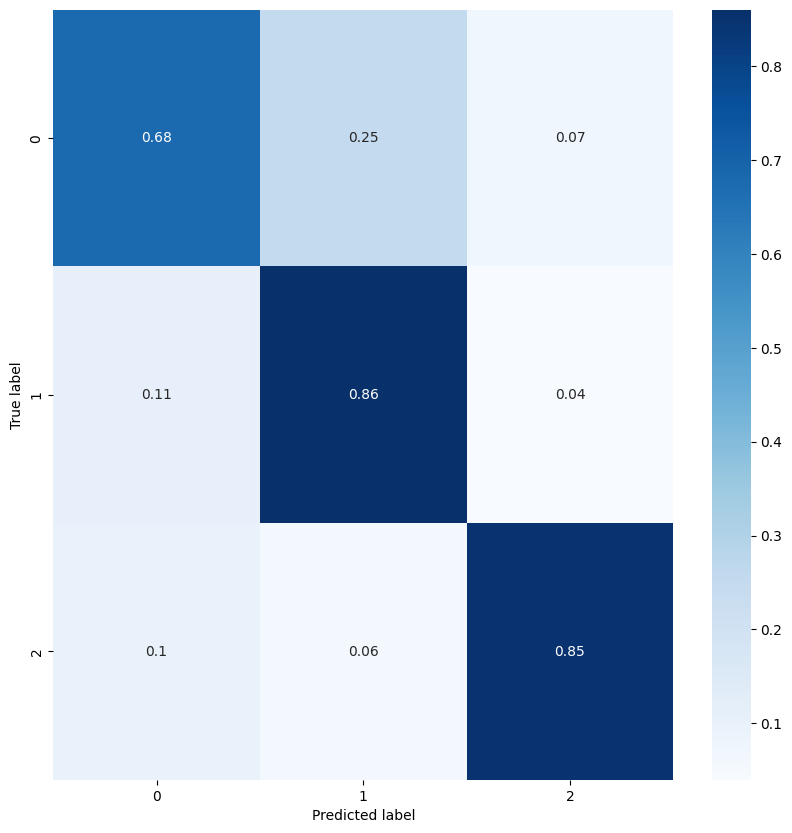

In [34]:
plot_confusion_matrix(X_test, y_test, model)